In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, LeakyReLU, UpSampling2D, MaxPool2D, Reshape, Flatten

from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train = (x_train / 255.) * 2 - 1
x_test = (x_test / 255.) * 2 - 1

print(x_train.min(), x_train.max())
print(x_test.min(), x_test.max())

x_train, x_test = np.expand_dims(x_train.astype("float32"), axis=-1), np.expand_dims(x_test.astype("float32"), axis=-1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
-1.0 1.0
-1.0 1.0
(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [2]:
K.clear_session()
codings_size = 100
generator = Sequential([
    Dense(7 * 7 * 128, input_shape=[codings_size]),
    Reshape([7, 7, 128]),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")
])

discriminator = Sequential([
    Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2), input_shape=[28, 28, 1]),
    Dropout(0.4),
    Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2)),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation="sigmoid")
])

gan = Sequential([generator, discriminator])

discriminator.compile(optimizer="rmsprop", loss="binary_crossentropy")
discriminator.trainable = False
gan.compile(optimizer="rmsprop", loss="binary_crossentropy")

In [3]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [4]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    gen, disc = gan.layers
    for epoch in range(n_epochs):
        for x_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_batch = gen(noise)
            full_batch = tf.concat([generated_batch, x_batch], axis=0)
            y1 = tf.constant(tf.concat([tf.zeros([batch_size, 1]), tf.ones([batch_size, 1])], axis=0))
            disc.trainable = True
            disc.train_on_batch(full_batch, y1)

            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.ones([batch_size, 1])
            disc.trainable = False

            gan.train_on_batch(noise, y2)


train_gan(gan, dataset, batch_size, codings_size)

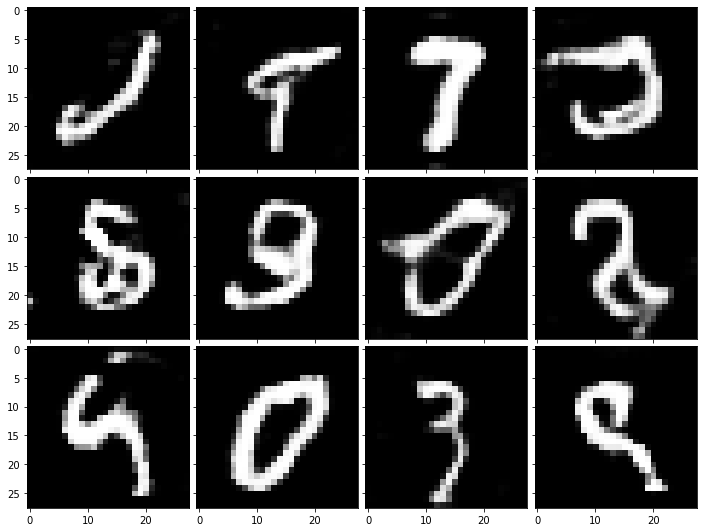

In [6]:
random_codings = tf.random.normal(shape=[12, codings_size])
images = generator(random_codings).numpy().squeeze()

fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(3, 4),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap="gray")

plt.show()